In [1]:
import pdbtools 

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

import glob, os

In [2]:
pdb_list = []
for g in glob.glob("tor/*.tor"):
    pdb = g[:4]
    chain = g[4]
    pdb_list.append((pdb,chain)) 
    
pdb_set = list(set(pdb_list))
#pdb_set = [p for p in pdb_set if not os.path.isfile(p)]

#pdbtools.download.pdbDownload(pdb_set)

In [3]:

def load_torsions(pdb_file,filter_chain):
    
    torsions = pdbtools.torsion.pdbTorsion(open(pdb_file).readlines())

    phi = []
    psi = []
    residue = []
    chain = []
    aa = []
    for i in range(len(torsions[0])):


        col = torsions[1][i].split()
        if len(col) < 3:
            continue
        aa.append(col[0])
        chain.append(col[1])
        residue.append(int(col[2]))
        
        phi.append(torsions[0][i][0])
        psi.append(torsions[0][i][1])

    out = pd.DataFrame({"chain":chain,"residue":residue,"aa":aa,"phi":phi,"psi":psi})
    if filter_chain != "_":
        out = out[out.chain == filter_chain]

    return out
    

df = None
for p in pdb_set:
    if os.path.isfile("{}.pdb".format(p[0])):
        new_df = load_torsions("{}.pdb".format(p[0]),filter_chain=p[1])
        if df is None:
            df = new_df.copy()
        else:
            tmp = df.append(new_df)
            df = tmp.reset_index(drop=True)

In [6]:
df.to_csv("all-torsion.csv")

In [6]:
df.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [64]:
tor_set = glob.glob("tor/*.tor")

def load_tor_file(tor_file):
    
    chain = []
    residue = []
    aa = []
    phi = []
    psi = []
    with open(tor_file) as f:
        for i, line in enumerate(f.readlines()):

            if i == 1:
                c = line[0:2].strip()
            if i < 2:
                continue
                
            if line[99] != "C":
                continue
                
                
            r = int(line[:8])
            a = line[11:14]
            ph = float(line[15:25])
            ps = float(line[26:36])
            

            chain.append(c)
            residue.append(r)
            aa.append(a)
            phi.append(ph)
            psi.append(ps)
            
    out = pd.DataFrame({"chain":chain,"residue":residue,"aa":aa,"phi":phi,"psi":psi})
    return out
        

coil_conly_df = None
for t in tor_set:
    new_df = load_tor_file(t) 
    if coil_conly_df is None:
        coil_conly_df = new_df.copy()
    else:
        tmp = coil_conly_df.append(new_df)
        coil_conly_df = tmp.reset_index(drop=True)


    

In [65]:
coil_conly_df.to_csv("coil-conly-torsion.csv")

In [11]:
#coil_df.to_csv("coil-torsion.csv")

In [12]:
all_df = pd.read_csv("all-torsion.csv")

,chain,residue,aa,phi,psi
0,S,87,ASN,-102.3264,141.8750
1,S,88,LYS,-104.5779,146.9348
2,S,89,LEU,-48.6333,-32.0852
3,S,90,ASN,-72.9086,-4.2009
4,S,91,GLY,90.7920,20.3254
...,...,...,...,...,...
151923,B,121,GLU,-71.6225,-17.6879
151924,B,122,PHE,-85.2600,69.5438
151925,B,123,THR,-74.7191,163.5879
151926,B,124,PRO,-45.1896,-51.1442


In [10]:
coil_df = pd.read_csv("coil-torsion.csv")

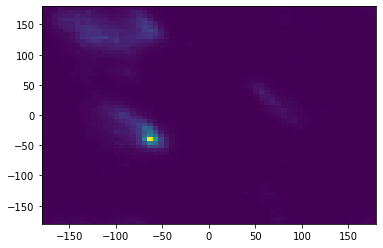

In [18]:
def create_hist(input_df,num_bins=60):

    h = plt.hist2d(input_df.phi,input_df.psi,bins=num_bins)
    plt.show()

    counts = h[0]
    phi = h[1]
    psi = h[2]
    freq = counts/np.sum(counts)

    out = {"phi":[],"psi":[],"prob":[]}
    for i in range(len(phi)-1):
        for j in range(len(psi)-1):
            out["phi"].append((phi[i] + phi[i+1])/2)
            out["psi"].append((psi[j] + psi[j+1])/2)
            out["prob"].append(freq[i,j])

    out_freq = pd.DataFrame(out)
    out_freq.prob[out_freq.prob == 0] = 1e-12
    
    return out_freq

#all_freq = create_hist(all_df)
coil_freq = create_hist(coil_df)
    

In [21]:
coil_freq.to_csv("coil.csv")

In [1]:
S_all = np.sum(all_freq.prob*np.log(all_freq.prob))*0.008314

NameError: name 'np' is not defined

In [138]:
S_coil = np.sum(coil_freq.prob*np.log(coil_freq.prob))*0.008314*298*200

In [139]:
S_all - S_coil

222.43708133754217

In [260]:
all_freq.to_csv("native.csv")
coil_freq.to_csv("coil-conly-torsion.csv")

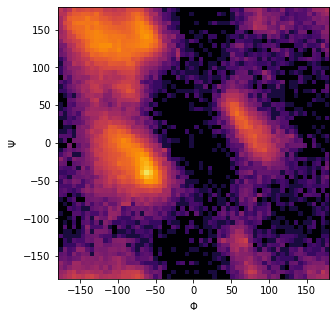

In [262]:
index = 0
out_matrix = np.zeros((60,60),dtype=np.float)
for i in range(60):
    for j in range(60):
        out_matrix[j,i] = np.log(coil_freq.prob[index]) #np.mean((-3,-13))
        index += 1
        

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(out_matrix,origin="lower",vmax=-3,vmin=-13,extent=(-180,180,-180,180),cmap="inferno")
#ax.imshow(out_matrix,origin="lower",vmax=-3,vmin=-13,extent=(-180,180,-180,180),cmap="inferno")
ax.set_aspect('equal', 'box')
ax.set_xlabel("$\Phi$")
ax.set_ylabel("$\Psi$")
        
plt.savefig("coil.png")